This tutorial shows how to use active learning to rapidly process a large dataset using a more computationally expensive method like docking, FEP, or 3D similarity calculations.  The code here is a scaled-down version of the code in our paper.  The code is fully functional.  I just removed a few of the options and benchmarks from our original work.  

In [77]:
from operator import itemgetter

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.gaussian_process as gp
import useful_rdkit_utils as uru
from modAL.acquisition import BaseLearner
from modAL.models import BayesianOptimizer
from modAL.utils.data import modALinput
from modAL.acquisition import optimizer_PI
from rdkit import Chem
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm.auto import tqdm
from modAL.utils.selection import multi_argmax

As with the classification example, we'll define an oracle that looks up values from a dataframe.  In practice, the oracle would perform some more expensive calculation like docking, FEP, or shape overlap. In practice, the oracle would perfrom some compute expensive function like docking or FEP. 

In [60]:
class Oracle:
    def __init__(self, df, col_name, invert=True):
        self.df = df
        self.col_name = col_name
        if invert:
            self.df[col_name] = self.df[col_name]

    def sample(self, num):
        sample_df = self.df.sample(num)
        return sample_df.fp.values, sample_df[self.col_name].values, sample_df.index

    def get_values(self, idx_list):
        return df[self.col_name].values[idx_list]

When we do active learning, we have to define a machine learning models that acts as a surrogate for the more expensive calculations.  In this case, we're going to use Gaussian Process Regression (GPR) to build our regression models.  To use GPR, we need to define a kernel function. Here we calculate a kernel based on the Tanimoto similarities of the molecules.

In [61]:
def calculate_similarity(a, b):
    # Tanimoto similarity a vs. b
    aa = np.sum(a, axis=1, keepdims=True)
    bb = np.sum(b, axis=1, keepdims=True)
    ab = np.matmul(a, b.T)
    return np.true_divide(ab, aa + bb.T - ab)


class TanimotoKernel(gp.kernels.NormalizedKernelMixin,
                     gp.kernels.StationaryKernelMixin, gp.kernels.Kernel):

    def __init__(self):
        pass

    def __call__(self, X, Y=None, eval_gradient=False):
        assert not eval_gradient
        if Y is None:
            Y = X
        return calculate_similarity(X, Y)

Enable progress bars for the Pandas apply function.

In [62]:
tqdm.pandas()

Read the input data.  This data comes from ["Optimizing active learning for free energy calculations"](https://www.sciencedirect.com/science/article/pii/S2667318522000204)

In [101]:
!ls *.csv

D2R_final.csv  MAPK1.csv      Mpro_final.csv


In [63]:
df = pd.read_csv("Mpro_final.csv")

Take a quick look at the data.

In [64]:
df

,SMILES,affinity,target,top_2p,top_5p
0,B1(OC(C(O1)(C)C)(C)C)c2cnc(nc2)C#N,7.004365,Mpro,False,False
1,C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)S[Au])O)O...,7.004365,Mpro,False,False
2,C1CN(CCN1C(=O)CCl)S(=O)(=O)C2=CCS=C2,9.314783,Mpro,False,False
3,C=CC(=O)N(c1ccc(cc1)C(F)(F)F)C(c2cc(cnc2)C#N)C...,8.521097,Mpro,False,False
4,C=CC(=O)N(c1ccc(cc1)C(F)(F)F)C(c2cc(cnc2)Cl)C(...,8.314930,Mpro,False,False
...,...,...,...,...,...
660,c1ccn2cnc(c2c1)NC(=O)Cc3cccc(c3)Cl,7.004365,Mpro,False,False
661,c1ccnc(c1)c2c(c[nH]n2)NC(=O)c3cccc4n3ccn4,7.004365,Mpro,False,False
662,c1cnc(nc1Cl)C#N,7.004365,Mpro,False,False
663,c1cscc1CN2CCN(CC2)C(=O)CCl,8.944124,Mpro,False,False


Create a LigandId column, we'll use this when we determine how many of the top 100 molecules we've identified. 

In [65]:
df["LigandId"] = range(0,len(df))

Add an RDKit molecule column to the dataframe.

In [66]:
df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/665 [00:00<?, ?it/s]

Add a fingerprint column to the dataframe.

In [67]:
df['fp'] = df.mol.progress_apply(uru.mol2morgan_fp)

  0%|          | 0/665 [00:00<?, ?it/s]

Create a pool for fingerprints for the active learning algorithm to draw from.

In [68]:
X_pool = np.stack(df.fp.values)

For the greedy search, we want to select the best scoring molecules, but we want to avoid selecting the same molecules multiple times. This function accepts a list of predictions and does the following.
- Sort by score
- Remove the molecules that were previously selected
- Return the top **n_to_choose**

In [69]:
def find_best_idx(predicted, used, num_to_choose):
    tmp_list = list(enumerate(predicted))
    tmp_list.sort(key=itemgetter(1), reverse=True)
    tmp_list = [x for x in tmp_list if x[0] not in used]
    tmp_list = [x[0] for x in tmp_list]
    return tmp_list[:num_to_choose]

Here are a couple of acquistion functions.  The first **greedy** simply selects the **n** top scoring molecules to be evaluated by the oracle.  The second **my_max_PI** maximizes the Probability of Improvement (PI) and uses uncertainty and the scores to balance exploration and exploitation.  The git repo associated with our paper ["Optimizing active learning for free energy calculations"](https://www.sciencedirect.com/science/article/pii/S2667318522000204) has examples of several other acquistion functions.  TLDR from our work, the acquistion function doesn't make a huge difference. 

In [102]:
def greedy(optimizer: BaseLearner, X: modALinput, n_instances=1, used=[]):
    res = optimizer.predict(X)
    best_idx = find_best_idx(res, used, n_instances)
    return best_idx, X[best_idx]

def my_max_PI(optimizer: BaseLearner, X: modALinput, tradeoff: float = 0,
           n_instances: int = 1, used = [], cycle = -1) -> np.ndarray:
    pi = optimizer_PI(optimizer, X, tradeoff=tradeoff)
    best_idx = find_best_idx(pi, used, n_instances)
    return best_idx, X[best_idx]

Create an oracle that will return values.

In [95]:
value_column = "affinity"
oracle = Oracle(df, value_column)

This is the main active learning loop.

In [96]:
# number of molecules to select at each active learning cycle
n_instances = 50
# number of active learning cycles to run
n_cycles = 5

# define the acquistion function
query_strategy = my_max_PI
# select an initial random cycle
X_initial, y_initial, sample_idx = oracle.sample(n_instances)
# instantiate the optimizer with an estimator, training data, and an acquistion function
optimizer = BayesianOptimizer(estimator=GaussianProcessRegressor(kernel=TanimotoKernel()),
                              X_training=np.stack(X_initial), y_training=y_initial,
                              query_strategy=query_strategy)
# initialize a list of scores
val_list = [y_initial]
# keep track of which molecules we've sampled
used = list(sample_idx)
# the active learning loop
for i in tqdm(range(0, n_cycles)):
    # ask the optimizer for the next set of molecules
    query_idx, query_desc = optimizer.query(X_pool, n_instances=n_instances, used=used)
    # get values from the oracle, in practice, this is where we would do the more expensive calculations
    vals = oracle.get_values(query_idx)
    # add the returned values to val_list
    val_list.append(vals)
    # keep track of the molecules we've used
    used += query_idx
    # update the optimizer with the new values
    optimizer.teach(query_desc, vals)

  0%|          | 0/5 [00:00<?, ?it/s]

Let's see how many of the top 100 molecules we found.

In [97]:
# sort the initial dataframe by score
ref_df = df.sort_values(value_column, ascending=False).head(100).copy()
# create a new dataframe with the selected molecules and sort by score
pick_df = df.iloc[used].sort_values(value_column, ascending=False).head(100).copy()
# merge the two dataframes to see how many molecules are in common
len(ref_df.merge(pick_df, on="LigandId"))

74

Let's look at how the scores were distributed across the active learning cycles. First we need to put the data in a dataframe.

In [98]:
res_list = []
for idx, v in enumerate(val_list):
    res_list += [(idx, x) for x in v]
res_df = pd.DataFrame(res_list, columns=["cycle", value_column])
# add row numbers for the selected molecules
res_df['mol_idx'] = used
# add the SMILES for the selected molecules 
res_df['SMILES'] = df.SMILES.values[used]
# reorder the columns in res_df
res_df = res_df[['SMILES','cycle','mol_idx','affinity']]
res_df

,SMILES,cycle,mol_idx,affinity
0,c1ccc(cc1)CN2CCC(c3c2ccc(c3)Cl)C(=O)Nc4cncc5c4...,0,524,8.807668
1,COc1ccccc1NCCNC(=O)c2cc(=O)[nH]c3c2cccc3,0,216,7.004365
2,CN(C)c1ccc(cc1)N(Cc2ccn[nH]2)C(=O)Cn3c4ccccc4nn3,0,145,7.042117
3,c1ccc(c(c1)CCS(=O)(=O)N)CN2CCN(CC2)C(=O)CCl,0,512,9.078974
4,c1cc(cc(c1)Cl)CC(=O)Nc2cncc3c2nccc3,0,448,8.206262
...,...,...,...,...
295,Cn1cc(nc1)CN(c2ccc(cc2)OCc3ccccc3)C(=O)c4cnnn4...,5,402,7.004365
296,Cc1ccc(cc1Cl)NC2=C(C(=O)N(C2=O)Cc3cccnc3)c4ccccc4,5,302,7.491559
297,Cc1ccncc1NC(=O)CN2c3cc(ccc3OCC2=O)Cl,5,333,7.409746
298,Cc1ccncc1NC(=O)Cc2cc(cc(c2)Cl)OCc3nc(no3)C,5,356,7.615137


Plot the scores of the molecules selected in each active learning round.  Remember that the first active learning cycle was randomly selected. 

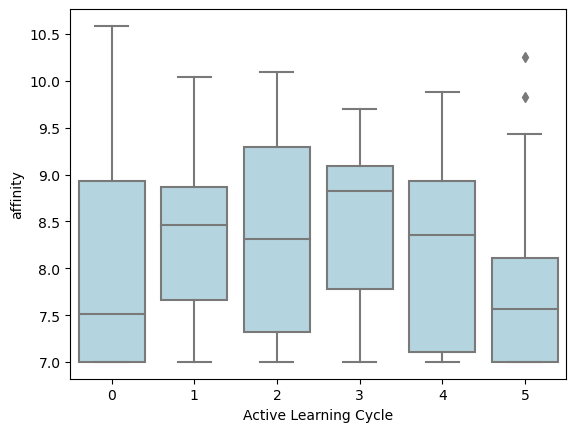

In [99]:
ax = sns.boxplot(x="cycle", y=value_column, data=res_df,color="lightblue")
ax.set_xlabel("Active Learning Cycle");

Now let's plot the distributions for the top 100 molecules from the input data vs the top 100 found using active learning.

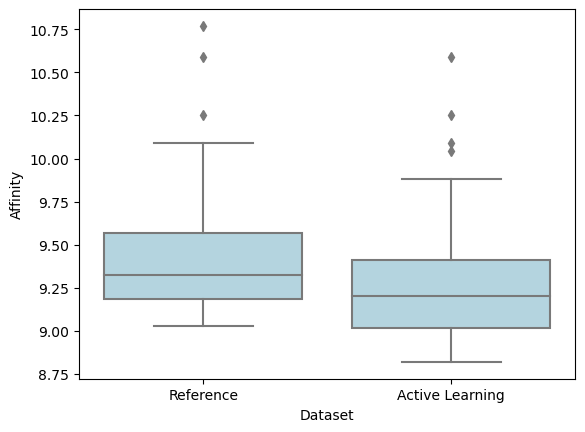

In [100]:
# Get a dataframe with the top 100 reference molecules
ref_top_100 = ref_df.sort_values("affinity",ascending=False).head(100).copy()
ref_top_100['Dataset'] = 'Reference'
# Get a dataframe with top 100 molecules predicted by active learning
pred_top_100 = res_df.sort_values("affinity",ascending=False).head(100).copy()
pred_top_100['Dataset'] = 'Active Learning'
# Make a boxplot comparing the scores of the top 100 molecules
ax = sns.boxplot(x="Dataset", y="affinity", data=pd.concat([ref_top_100,pred_top_100]),color="lightblue");
ax.set_ylabel("Affinity");

We can also compare the scores of the molecules selected by active learning with scores from randomly selected molecules. 

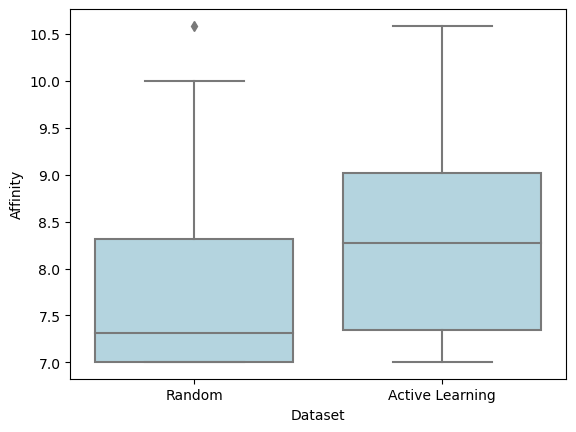

In [56]:
# Take a random sample from the input data that is the same size as the dataframe with the selected molecules
random_df = df.sample(len(res_df)).copy()
random_df['Dataset'] = 'Random'
# Label the active learning data
res_df['Dataset'] = 'Active Learning'
ax = sns.boxplot(x="Dataset", y="affinity", data=pd.concat([random_df,res_df]),color="lightblue");
ax.set_ylabel("Affinity");